In [14]:
# Load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data_loc = 'D:/Reddit NBA Data/'

file_name = 'nba_comments_scored.tsv'
df = pd.read_csv(data_loc + file_name, sep='\t')


C:\Users\mattg\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,9,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
#Merge player race on and create black category
print(len(df))
pl = pd.read_csv(data_loc + 'players2018.tsv', sep='\t')
pl['fuzzy_name'] = pl['Player'].str.lower()
df = df.merge(pl, on='fuzzy_name', how='left')
df['black'] = df['Race'].isin(['B','M'])
print(len(df))

3849403
3849403
['compound' 'flair' 'fuzzy_name' 'named_entities' 'neg' 'neu' 'pos'
 'score' 'season' 'source' 'str_entities' 'text_length' 'timestamp'
 'upper_entities' 'user' 'year_month' 'Player' 'From' 'To' 'Pos' 'Ht' 'Wt'
 'Birth Date' 'Colleges' 'experience' 'Race' 'black']


In [3]:
#create score_mod which is arctan transform of score and has more sensible distribution
df['score_mod'] = np.arctan(df['score'])
#df['score_mod']= df['score']
print(df['score'].describe())
print(df['score_mod'].describe())

count    2.729808e+06
mean     1.632070e+01
std      1.881786e+02
min     -7.170000e+02
25%      1.000000e+00
50%      2.000000e+00
75%      6.000000e+00
max      3.399600e+04
Name: score, dtype: float64
count    2.729808e+06
mean     9.365359e-01
std      6.400663e-01
min     -1.569402e+00
25%      7.853982e-01
50%      1.107149e+00
75%      1.405648e+00
max      1.570767e+00
Name: score_mod, dtype: float64


In [4]:
#List of top entities
threshold = 5000
players = df['fuzzy_name'].value_counts()
player_list = [p for p in players[players>threshold].index.values if p!='unclear']

In [5]:
#Regression onto player effects and seperate pos, neg effects for black/white
#Weak evidence that baseline arctan karma is slightly higher for non-black player
#no evidence that sentiment impacts karma differently for black/white players (power is pretty high) 
#overall this is pretty strong evience against racial bias
import statsmodels.formula.api as smf
from sklearn.linear_model import LassoCV

df_use = df[df['fuzzy_name'].isin(player_list)]
df_use = df_use.loc[:, ['score_mod','pos','neg','black','fuzzy_name']].dropna(how='any')

                     
mod = smf.wls('score_mod ~ (pos + neg) * black',
              data=df_use).fit(cov_type='cluster', cov_kwds={'groups' : df_use['fuzzy_name']})
print(mod.summary())

                            WLS Regression Results                            
Dep. Variable:              score_mod   R-squared:                       0.001
Model:                            WLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     29.81
Date:                Sun, 18 Nov 2018   Prob (F-statistic):           3.45e-16
Time:                        01:04:45   Log-Likelihood:            -1.1816e+06
No. Observations:             1150380   AIC:                         2.363e+06
Df Residuals:                 1150374   BIC:                         2.363e+06
Df Model:                           5                                         
Covariance Type:              cluster                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.9486      0.01

In [6]:
#Now lets add player fixed effects to better control for player heterogeneity and see who the poppular players are
import statsmodels.formula.api as smf
from sklearn.linear_model import LassoCV

mod = smf.wls('score_mod ~ -1 + C(fuzzy_name) + (pos + neg):black', data=df_use) \
.fit(cov_type='cluster', cov_kwds={'groups' : df_use['fuzzy_name']})
par=pd.concat([mod.params, mod.HC0_se], axis=1)
par.columns=['coef','se']
par['t'] = par['coef'] / par['se']

In [7]:
#Negative sentiment predicts less arctan karma on average. But it does so similarly for black and white players
#Positive sentiment does not predict arctan karma on average.
par_coef = par.loc[~par.index.get_level_values(None).str.contains('fuzzy'), :]
print(par_coef.sort_values('coef', ascending=False))

                      coef        se          t
pos:black[True]  -0.006660  0.004567  -1.458219
pos:black[False] -0.014162  0.008211  -1.724723
neg:black[True]  -0.137453  0.005860 -23.457627
neg:black[False] -0.142468  0.010993 -12.960359


In [8]:
#What about the overall level of karma for posts about individual players?
#To check, we sort player fixed effects and print them. Some intresting names on top and bottom of the list

par_fe = par.loc[par.index.get_level_values(None).str.contains('fuzzy'), :]
print(par_fe.sort_values('coef', ascending=False))

                                          coef        se           t
C(fuzzy_name)[chuck hayes]            1.041675  0.006829  152.537176
C(fuzzy_name)[manu ginobili]          1.036552  0.006738  153.837863
C(fuzzy_name)[thon maker]             1.036352  0.008718  118.870032
C(fuzzy_name)[nikola jokic]           1.026339  0.006681  153.610941
C(fuzzy_name)[doc rivers]             1.022460  0.007466  136.944140
C(fuzzy_name)[jj redick]              1.017685  0.007659  132.873865
C(fuzzy_name)[dirk nowitzki]          1.017019  0.005308  191.598250
C(fuzzy_name)[kristaps porzingis]     1.013561  0.007378  137.371789
C(fuzzy_name)[enes kanter]            1.006074  0.007791  129.129121
C(fuzzy_name)[cj mccollum]            1.004483  0.006813  147.433620
C(fuzzy_name)[pau gasol]              0.996576  0.007850  126.947986
C(fuzzy_name)[javale mcgee]           0.996536  0.006893  144.561860
C(fuzzy_name)[dwane casey]            0.995208  0.007477  133.110415
C(fuzzy_name)[kemba walker]       

In [9]:
#what about a fully general model that gives player specific slopes for pos and neg sentiment
mod = smf.wls('score_mod ~ -1 + C(fuzzy_name) + C(fuzzy_name):(pos + neg)', data=df_use) \
.fit(cov_type='cluster', cov_kwds={'groups' : df_use['fuzzy_name']})
par=pd.concat([mod.params, mod.HC0_se], axis=1)
par.columns=['coef','se']
par['t'] = par['coef'] / par['se']


In [10]:
#Print player fixed effects. This gives fitted player sentiment when pos=neg=0 for each player. Essnetially this gives us a
#sentiment-neutral level of arctan karma for each player
par_lvl = par[~(par.index.get_level_values(None).str.contains('pos') | par.index.get_level_values(None).str.contains('neg'))]
print(par_lvl.sort_values('coef',ascending=False))

                                          coef        se           t
C(fuzzy_name)[nikola jokic]           1.033241  0.008982  115.032608
C(fuzzy_name)[chuck hayes]            1.027490  0.009589  107.155387
C(fuzzy_name)[jj redick]              1.027125  0.013383   76.747571
C(fuzzy_name)[kristaps porzingis]     1.026857  0.009738  105.452306
C(fuzzy_name)[dirk nowitzki]          1.022574  0.006934  147.465651
C(fuzzy_name)[manu ginobili]          1.020076  0.009097  112.138509
C(fuzzy_name)[javale mcgee]           1.017174  0.009322  109.116088
C(fuzzy_name)[thon maker]             1.011168  0.012060   83.841487
C(fuzzy_name)[doc rivers]             1.004314  0.010167   98.785697
C(fuzzy_name)[enes kanter]            1.000014  0.010947   91.349471
C(fuzzy_name)[dwane casey]            0.997323  0.010291   96.913246
C(fuzzy_name)[andre roberson]         0.996859  0.013138   75.874238
C(fuzzy_name)[bradley beal]           0.988274  0.010916   90.531206
C(fuzzy_name)[kemba walker]       

                                              coef        se         t
C(fuzzy_name)[thon maker]:pos             0.162777  0.047163  3.451362
C(fuzzy_name)[andre drummond]:pos         0.118490  0.052783  2.244860
C(fuzzy_name)[chris paul]:pos             0.112538  0.055946  2.011530
C(fuzzy_name)[jeremy lin]:pos             0.112147  0.050429  2.223853
C(fuzzy_name)[serge ibaka]:pos            0.110539  0.044085  2.507382
C(fuzzy_name)[cj mccollum]:pos            0.109994  0.037243  2.953393
C(fuzzy_name)[pau gasol]:pos              0.092969  0.042239  2.201018
C(fuzzy_name)[lamarcus aldridge]:pos      0.090793  0.037188  2.441448
C(fuzzy_name)[nerlens noel]:pos           0.086618  0.045846  1.889335
C(fuzzy_name)[manu ginobili]:pos          0.078212  0.034969  2.236647
C(fuzzy_name)[chuck hayes]:pos            0.075055  0.036888  2.034702
C(fuzzy_name)[andrew bogut]:pos           0.074975  0.047887  1.565671
C(fuzzy_name)[andrew wiggins]:pos         0.073853  0.040253  1.834706
C(fuzz

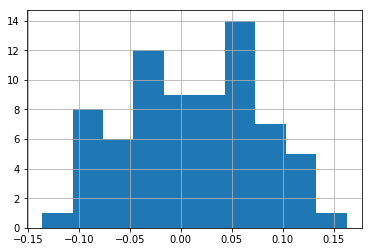

In [11]:
#Print and sort list of impact of pos on karma for each player. Guys on top of this list are ones we "love to see celebrated"
#Note this is centered around 0 and there isn't a whole lot of statistical significance going on here
par_pos = par[par.index.get_level_values(None).str.contains('pos')]
print(par_pos.sort_values('coef',ascending=False))
par_pos['coef'].hist()
plt.show()

                                              coef        se          t
C(fuzzy_name)[jayson tatum]:neg           0.099975  0.046598   2.145460
C(fuzzy_name)[markelle fultz]:neg         0.092857  0.049108   1.890881
C(fuzzy_name)[kemba walker]:neg           0.076899  0.051430   1.495222
C(fuzzy_name)[anthony davis]:neg          0.076179  0.096068   0.792972
C(fuzzy_name)[karl-anthony towns]:neg     0.042117  0.044835   0.939391
C(fuzzy_name)[rudy gobert]:neg            0.039024  0.056374   0.692228
C(fuzzy_name)[pau gasol]:neg              0.028645  0.053827   0.532166
C(fuzzy_name)[cj mccollum]:neg            0.028389  0.049509   0.573411
C(fuzzy_name)[kyrie irving]:neg           0.010406  0.029326   0.354844
C(fuzzy_name)[lonzo ball]:neg             0.004906  0.035439   0.138444
C(fuzzy_name)[paul george]:neg           -0.001498  0.074268  -0.020166
C(fuzzy_name)[lamarcus aldridge]:neg     -0.006783  0.045366  -0.149514
C(fuzzy_name)[damian lillard]:neg        -0.012635  0.053531  -0

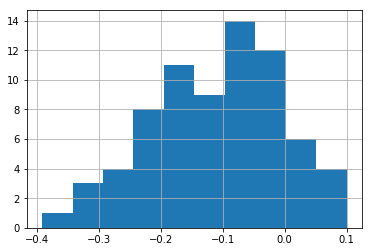

In [12]:
#Print and sort list of impact of pos on karma for each player. Guys on top of this list are ones we "love to see hated on"
#Centered around negative values and lots of statistically significant variation here.
import matplotlib.pyplot as plt
par_neg = par[par.index.get_level_values(None).str.contains('neg')]
print(par_neg.sort_values('coef',ascending=False))
par_neg['coef'].hist()
plt.show()